### Interpret Results

##### Imports and Key Functions


In [1]:
# Run this script to add the src directory to the python path

from notebook_utils import modify_sys_path, get_parent_dir_path, set_plot_style

modify_sys_path()
set_plot_style()

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import re
from csaps import csaps


from src.utils import calculate_min_Va_by_KL_threshold, calculate_min_Va_by_KL_rank



In [3]:

PROB_LABELS = ["0", "1"]

feature_column = 'x1'

def get_shots_df(results_directory, num_valid_Va: int=5, feature_column='x1') -> pd.DataFrame:
    # Load the results
    df_list = []
    for filename in os.listdir(get_parent_dir_path(results_directory)):
        if f"results_" in filename:
            save_data = pd.read_csv(get_parent_dir_path(results_directory) + filename)
            df_list.append(save_data)
    
    for save_data in df_list:
        save_data["Var[y|x,D]"] = save_data["Var[p(y|x,D)]"]
        save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=num_valid_Va, forward_kl=True, upper_bound_by_total_U=True)
        save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=num_valid_Va, forward_kl=True, upper_bound_by_total_U=True, uncertainty_type="variance")
    
    x_x1_list = []
    total_uncertainty_list = []
    min_Va_list = []    
    max_Ve_list = []
    
    kl_pyx_pyxz_list = []

    
    within_threshold_list = []

    total_variance_list = []
    min_Va_variance_list = []
    max_Ve_variance_list = []


    for z_df in df_list:
        try:
            x_x1 = z_df[f'x_{feature_column}'].values[0]
            x_x1_list.append(x_x1)
            total_uncertainty = z_df["H[p(y|x,D)]"].values[0]
            total_uncertainty_list.append(total_uncertainty)
            
            min_Va = z_df["min_Va"].values[0]
            min_Va_list.append(min_Va)
            max_Ve = z_df["max_Ve"].values[0]
            max_Ve_list.append(max_Ve)
            
            within_threshold_list.append(z_df[z_df["within_threshold"]][f"z_{feature_column}"].values)
            
            min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
            
            kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
            kl_pyx_pyxz_list.append(kl_pyx_pyxz)
            
        except:
            pass
        
        try:
            total_variance = z_df["Var[y|x,D]"].values[0]
            total_variance_list.append(total_variance)
            
            min_Va_variance = z_df["min_Va_variance"].values[0]
            min_Va_variance_list.append(min_Va_variance)   
            
            max_Ve_variance = z_df["max_Ve_variance"].values[0]
            max_Ve_variance_list.append(max_Ve_variance)
        except:
            pass     
        
    # Create a dataframe from the lists
    data = {f'x_{feature_column}': x_x1_list,
            'total_uncertainty': total_uncertainty_list,
            'min_Va': min_Va_list,
            'max_Ve': max_Ve_list,
            'within_threshold': within_threshold_list,
            'kl_pyx_pyxz': kl_pyx_pyxz_list,
            }

    if len(total_variance_list) > 0:
        data['total_variance'] = total_variance_list
        data['min_Va_variance'] = min_Va_variance_list
        data['max_Ve_variance'] = max_Ve_variance_list

    num_Va = len(min_Va_list)

    # reduce the length of list to the number of num_Va
    for key in data.keys():
        data[key] = data[key][:num_Va]

    shots_df = pd.DataFrame(data)

    shots_df = shots_df.sort_values(by='x_x1')
    
    return shots_df


#### Plot Single Decomposition

In [4]:
RESULTS_DIRECTORY = 'results/toy_classification/experiment_2/'

In [5]:
D_data = None

for filename in os.listdir(get_parent_dir_path(RESULTS_DIRECTORY)):
    if f"D_" in filename:
        D_data = pd.read_csv(get_parent_dir_path(RESULTS_DIRECTORY) + filename)
        
feature_column = [col for col in D_data.columns if col != 'label' and col != 'note'][0]

shots_df = get_shots_df(RESULTS_DIRECTORY, num_valid_Va=5)


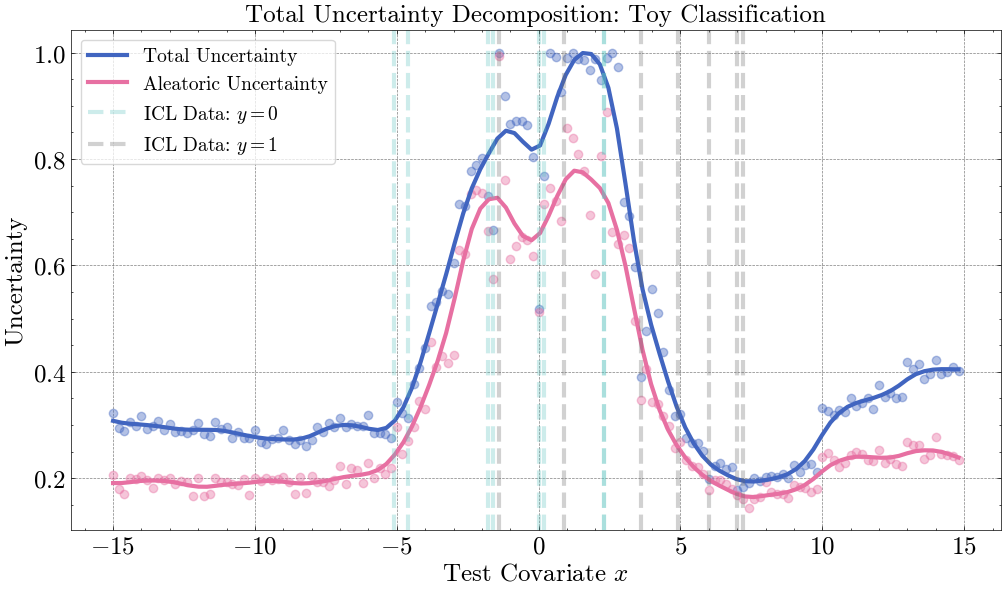

In [6]:
# total uncertainty decomposition

fig, ax = plt.subplots(figsize=(12, 6.5))
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['total_uncertainty'], color='C0', alpha=0.4)
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['min_Va'], color='C1', alpha=0.4)

# line of best fit

x_grid = np.linspace(shots_df[f'x_{feature_column}'].min(), shots_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty = csaps(shots_df[f'x_{feature_column}'], shots_df['total_uncertainty'], smooth=0.85)
y_min_Va = csaps(shots_df[f'x_{feature_column}'], shots_df['min_Va'], smooth=0.85)

plt.plot(x_grid, y_total_uncertainty(x_grid), color='C0', linewidth = 3, label='Total Uncertainty')
plt.plot(x_grid, y_min_Va(x_grid), color='C1', linewidth = 3, label='Aleatoric Uncertainty')

# vertical line for the true x
label_0_seen = False
label_1_seen = False
for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = r'ICL Data: $y = 0$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C2', linestyle='--', linewidth=3, alpha=0.3, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = r'ICL Data: $y = 1$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C3', linestyle='--', linewidth=3, alpha=0.3, label=label_string)
        
plt.title("Total Uncertainty Decomposition: Toy Classification")
plt.ylabel('Uncertainty')
plt.xlabel(r'Test Covariate $x$')

plt.legend(framealpha=0.75)

plt.show()

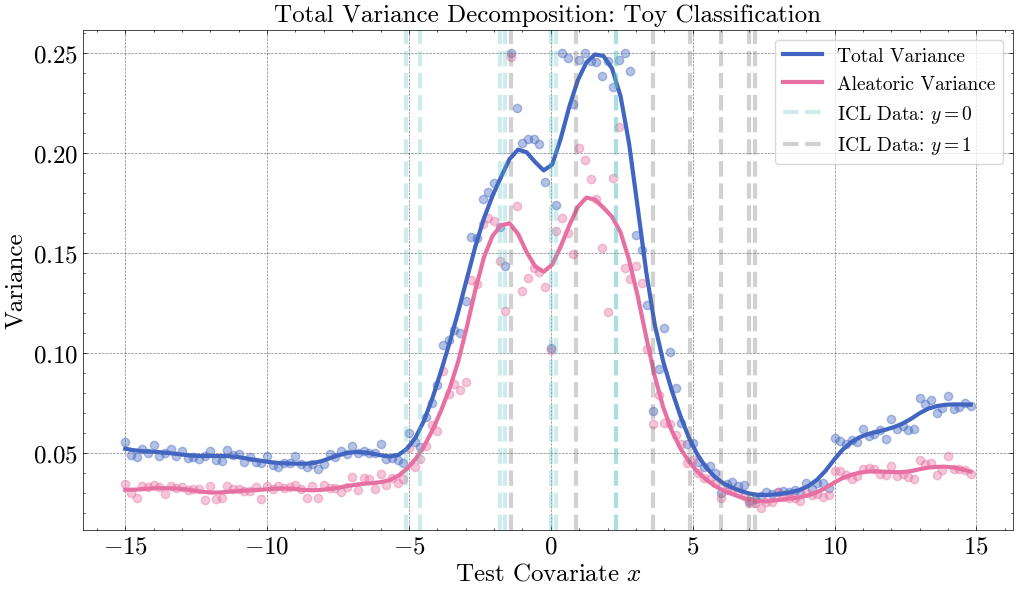

In [7]:
# total variance decomposition

fig, ax = plt.subplots(figsize=(12, 6.5))
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['total_variance'], color='C0', alpha=0.4)
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['min_Va_variance'], color='C1', alpha=0.4)

# line of best fit

x_grid = np.linspace(shots_df[f'x_{feature_column}'].min(), shots_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty = csaps(shots_df[f'x_{feature_column}'], shots_df['total_variance'], smooth=0.85)
y_min_Va = csaps(shots_df[f'x_{feature_column}'], shots_df['min_Va_variance'], smooth=0.85)

plt.plot(x_grid, y_total_uncertainty(x_grid), color='C0', linewidth = 3, label='Total Variance')
plt.plot(x_grid, y_min_Va(x_grid), color='C1', linewidth = 3, label='Aleatoric Variance')

# vertical line for the true x
label_0_seen = False
label_1_seen = False
for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = r'ICL Data: $y = 0$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C2', linestyle='--', linewidth=3, alpha=0.3, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = r'ICL Data: $y = 1$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C3', linestyle='--', linewidth=3, alpha=0.3, label=label_string)
        
plt.title("Total Variance Decomposition: Toy Classification")
plt.ylabel('Variance')
plt.xlabel(r'Test Covariate $x$')

plt.legend(framealpha=0.75)

plt.show()

#### Comparison of Decompositions

In [8]:
results_pre_directory = 'results/toy_classification/'

shots = 15

results_directories = [f"{results_pre_directory}experiment_{i}/" for i in [1, 2, 3, 4]]

labels = ['BO', 'Perturb', 'Repeated', 'Random']


In [9]:
D_data = None

for filename in os.listdir(get_parent_dir_path(results_directories[0])):
    if f"D_{shots}" in filename:
        D_data = pd.read_csv(get_parent_dir_path(results_directories[0]) + filename)
        
shots_dfs = [get_shots_df(results_directory, shots=15, num_valid_Va=5) for results_directory in results_directories]

for i, shots_df in enumerate(shots_dfs):
    shots_df['method'] = labels[i]
    
joint_shots_df = pd.concat(shots_dfs, ignore_index=True, axis=0)
joint_shots_df = joint_shots_df.reset_index(drop=True)

TypeError: get_shots_df() got an unexpected keyword argument 'shots'

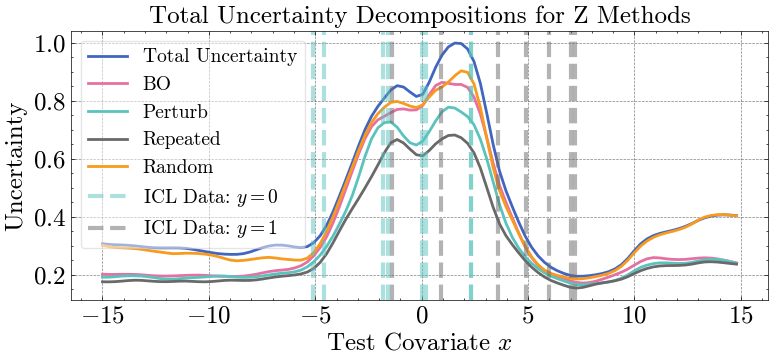

In [ ]:
fig, ax = plt.subplots(figsize=(9, 3.5))
# line of best fit

x_grid = np.linspace(shots_dfs[0][f'x_{feature_column}'].min(), shots_dfs[0][f'x_{feature_column}'].max(), 100)

y_total_uncertainty = csaps(shots_dfs[0][f'x_{feature_column}'], shots_dfs[0]['total_uncertainty'], smooth=0.85)

y_min_Va_list = [csaps(shots_df[f'x_{feature_column}'], shots_df['min_Va'], smooth=0.85) for shots_df in shots_dfs]

plt.plot(x_grid, y_total_uncertainty(x_grid), color='C0', linewidth = 2, label='Total Uncertainty')
for i, y_min_Va in enumerate(y_min_Va_list):
    plt.plot(x_grid, y_min_Va(x_grid), color=f'C{i+1}', linewidth = 2, label=f'{labels[i]}')
    
# vertical line for the true x
label_0_seen = False
label_1_seen = False

for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = r'ICL Data: $y = 0$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C2', linestyle='--', linewidth=3, alpha=0.5, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = r'ICL Data: $y = 1$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C3', linestyle='--', linewidth=3, alpha=0.5, label=label_string)

plt.title("Total Uncertainty Decompositions for Z Methods")


plt.ylabel('Uncertainty')
plt.xlabel(r'Test Covariate $x$')
plt.legend(framealpha=0.5)

plt.show()

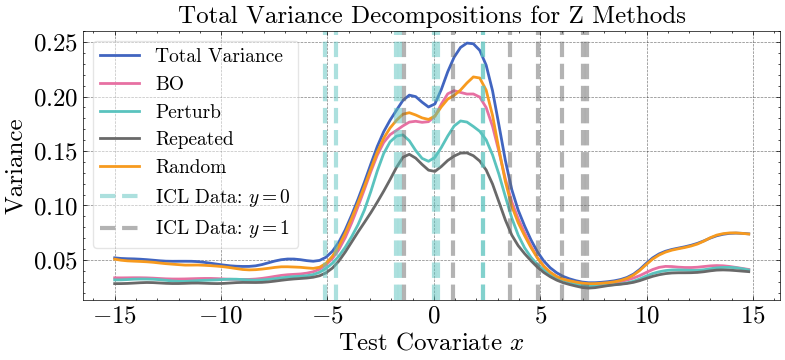

In [ ]:
fig, ax = plt.subplots(figsize=(9, 3.5))
# line of best fit

x_grid = np.linspace(shots_dfs[0][f'x_{feature_column}'].min(), shots_dfs[0][f'x_{feature_column}'].max(), 100)

y_total_uncertainty = csaps(shots_dfs[0][f'x_{feature_column}'], shots_dfs[0]['total_variance'], smooth=0.85)

y_min_Va_list = [csaps(shots_df[f'x_{feature_column}'], shots_df['min_Va_variance'], smooth=0.85) for shots_df in shots_dfs]

plt.plot(x_grid, y_total_uncertainty(x_grid), color='C0', linewidth = 2, label='Total Variance')
for i, y_min_Va in enumerate(y_min_Va_list):
    plt.plot(x_grid, y_min_Va(x_grid), color=f'C{i+1}', linewidth = 2, label=f'{labels[i]}')
    
# vertical line for the true x
label_0_seen = False
label_1_seen = False

for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = r'ICL Data: $y = 0$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C2', linestyle='--', linewidth=3, alpha=0.5, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = r'ICL Data: $y = 1$'
        else:
            label_string = None
        plt.axvline(x=row[feature_column], color='C3', linestyle='--', linewidth=3, alpha=0.5, label=label_string)

plt.title("Total Variance Decompositions for Z Methods")


plt.ylabel('Variance')
plt.xlabel(r'Test Covariate $x$')
plt.legend(framealpha=0.5)

plt.show()

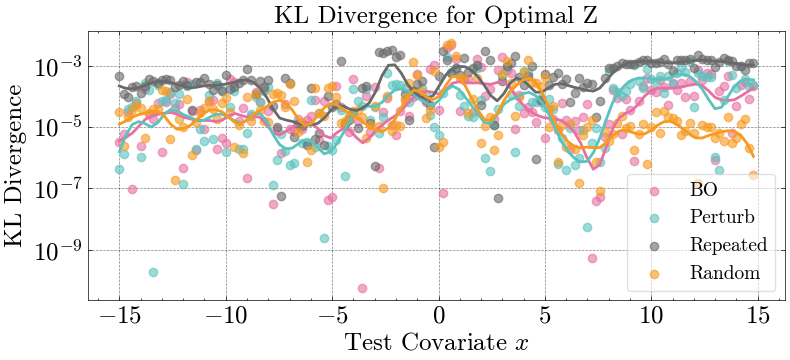

In [ ]:
### Plot KL Divergences

plt.figure(figsize=(9, 3.5))

kl_list = [csaps(shots_df[f'x_{feature_column}'], np.log(shots_df['kl_pyx_pyxz']), smooth=0.9) for shots_df in shots_dfs]
for i, shots_df in enumerate(shots_dfs):
    plt.plot(x_grid, np.exp(kl_list[i](x_grid)), color=f'C{i+1}', linewidth = 2)
    plt.scatter(shots_df['x_x1'], shots_df['kl_pyx_pyxz'], label=labels[i], color=f'C{i+1}', alpha=0.6)


plt.xlabel(r'Test Covariate $x$')
plt.ylabel(r'KL Divergence')
plt.title(rf"KL Divergence for Optimal Z")

plt.yscale('log')
plt.legend(framealpha=0.6)
plt.show()


In [ ]:
joint_shots_df['min_Va_rank'] = joint_shots_df.groupby('x_x1')['min_Va'].rank(method='min', ascending=True)

average_Va_ranks = np.round(joint_shots_df.groupby('method')['min_Va_rank'].agg(['mean', 'std']).reset_index(), 2)

joint_shots_df['min_kl_rank'] = joint_shots_df.groupby('x_x1')['kl_pyx_pyxz'].rank(method='min', ascending=True)

average_kl_ranks = np.round(joint_shots_df.groupby('method')['min_kl_rank'].agg(['mean', 'std']).reset_index(),2)

print("Average Va Ranks:")
print(average_Va_ranks)
print("Average KL Ranks:")
print(average_kl_ranks)